In [1]:
import os 
import statistics


from keras import backend, Model
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization, Dropout, Dense, LeakyReLU
from keras.utils.generic_utils import get_custom_objects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow_docs import plots as tfplots

In [2]:
def load(filename):
    return pd.read_csv(os.path.join('datasets/', filename)).set_index('ID')

In [3]:
os.chdir(os.getcwd())

## Import Data

Load all the dataset from the CSV files and inspect each datasets to get an overview of the data.

In [4]:
X_train, Y_train = load('X_train.csv'), load('Y_train.csv')
X_test = load('X_test.csv')

In [5]:
X_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,
21754,80000.0,2,2,2,24,0,0,0,0,0,...,78321.0,73731.0,39643.0,39457.0,3503.0,5001.0,2092.0,1218.0,1445.0,878.0
252,30000.0,1,2,2,28,0,0,0,0,0,...,29155.0,25255.0,22001.0,0.0,5006.0,1244.0,851.0,955.0,0.0,0.0
22942,180000.0,2,5,1,44,0,0,-1,-1,-1,...,850.0,0.0,6881.0,10340.0,0.0,850.0,0.0,6881.0,10340.0,182.0
619,60000.0,1,1,2,25,0,0,0,0,0,...,38533.0,39639.0,39619.0,39140.0,2018.0,1900.0,2000.0,1500.0,1900.0,2000.0
17091,130000.0,2,2,2,25,0,0,0,0,0,...,114734.0,117823.0,120854.0,123904.0,4100.0,4200.0,5000.0,5000.0,5000.0,10700.0


In [6]:
Y_train.head()

,default.payment.next.month
ID,
21754,0
252,0
22942,0
619,0
17091,0


In [7]:
X_test.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,
2309,30000.0,1,2,2,25,0,0,0,0,0,...,11581.0,12580.0,13716.0,14828.0,1500.0,2000.0,1500.0,1500.0,1500.0,2000.0
22405,150000.0,2,1,2,26,0,0,0,0,0,...,116684.0,101581.0,77741.0,77264.0,4486.0,4235.0,3161.0,2647.0,2669.0,2669.0
23398,70000.0,2,3,1,32,0,0,0,0,0,...,68530.0,69753.0,70111.0,70212.0,2431.0,3112.0,3000.0,2438.0,2500.0,2554.0
25059,130000.0,1,3,2,49,0,0,0,0,0,...,16172.0,16898.0,11236.0,6944.0,1610.0,1808.0,7014.0,27.0,7011.0,4408.0
2665,50000.0,2,2,2,36,0,0,0,0,0,...,42361.0,19574.0,20295.0,19439.0,2000.0,1500.0,1000.0,1800.0,0.0,1000.0


## Data Analysis & Preprocessing
Merge `X_train` and `Y_train` rows with the same indices to obtain the full `X` dataset.
The preprocessing stage first renames a few columns to conform it.

After inspecting the data through the `describe` function, some issues were detected in the `EDUCATION` and `MARRIAGE` columns.
These two columns has values outside the range described in the provided pdf file, therefore, all these unknown values will be replaced with the corresponding `Others` value.

In [8]:
X = pd.merge(X_train, Y_train, left_index=True, right_index=True)

X.rename(columns={'default.payment.next.month': 'PAY_NEXT_MONTH', 'PAY_0': 'PAY_1'}, inplace=True)
X_test.rename(columns={"PAY_0":"PAY_1",}, inplace=True)
X.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_NEXT_MONTH
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,...,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,167226.653333,1.604917,1.854000,1.551417,35.494375,-0.016667,-0.131375,-0.168167,-0.220417,-0.265167,...,43013.532167,40150.333000,38763.540458,5670.826542,5.961101e+03,5258.246500,4880.847125,4818.849250,5159.462125,0.221792
std,129734.959196,0.488879,0.792176,0.522766,9.235160,1.126473,1.197675,1.191685,1.168107,1.132949,...,64069.494705,60635.882129,59281.986863,17084.401034,2.428412e+04,18242.618988,16304.718844,15619.425964,17458.604219,0.415460
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-209051.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2329.000000,1763.000000,1271.750000,1000.000000,8.615000e+02,390.000000,285.750000,240.750000,112.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19010.000000,18085.000000,17108.500000,2100.000000,2.007000e+03,1800.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,53927.750000,50007.500000,49101.750000,5005.000000,5.000000e+03,4500.000000,4000.000000,4021.000000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,527143.000000,1.000000


In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 21754 to 23655
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   LIMIT_BAL       24000 non-null  float64
 1   SEX             24000 non-null  int64  
 2   EDUCATION       24000 non-null  int64  
 3   MARRIAGE        24000 non-null  int64  
 4   AGE             24000 non-null  int64  
 5   PAY_1           24000 non-null  int64  
 6   PAY_2           24000 non-null  int64  
 7   PAY_3           24000 non-null  int64  
 8   PAY_4           24000 non-null  int64  
 9   PAY_5           24000 non-null  int64  
 10  PAY_6           24000 non-null  int64  
 11  BILL_AMT1       24000 non-null  float64
 12  BILL_AMT2       24000 non-null  float64
 13  BILL_AMT3       24000 non-null  float64
 14  BILL_AMT4       24000 non-null  float64
 15  BILL_AMT5       24000 non-null  float64
 16  BILL_AMT6       24000 non-null  float64
 17  PAY_AMT1        24000 non-n

In [10]:
print('Missing data:')
X.isna().sum()

Missing data:


LIMIT_BAL         0
SEX               0
EDUCATION         0
MARRIAGE          0
AGE               0
PAY_1             0
PAY_2             0
PAY_3             0
PAY_4             0
PAY_5             0
PAY_6             0
BILL_AMT1         0
BILL_AMT2         0
BILL_AMT3         0
BILL_AMT4         0
BILL_AMT5         0
BILL_AMT6         0
PAY_AMT1          0
PAY_AMT2          0
PAY_AMT3          0
PAY_AMT4          0
PAY_AMT5          0
PAY_AMT6          0
PAY_NEXT_MONTH    0
dtype: int64

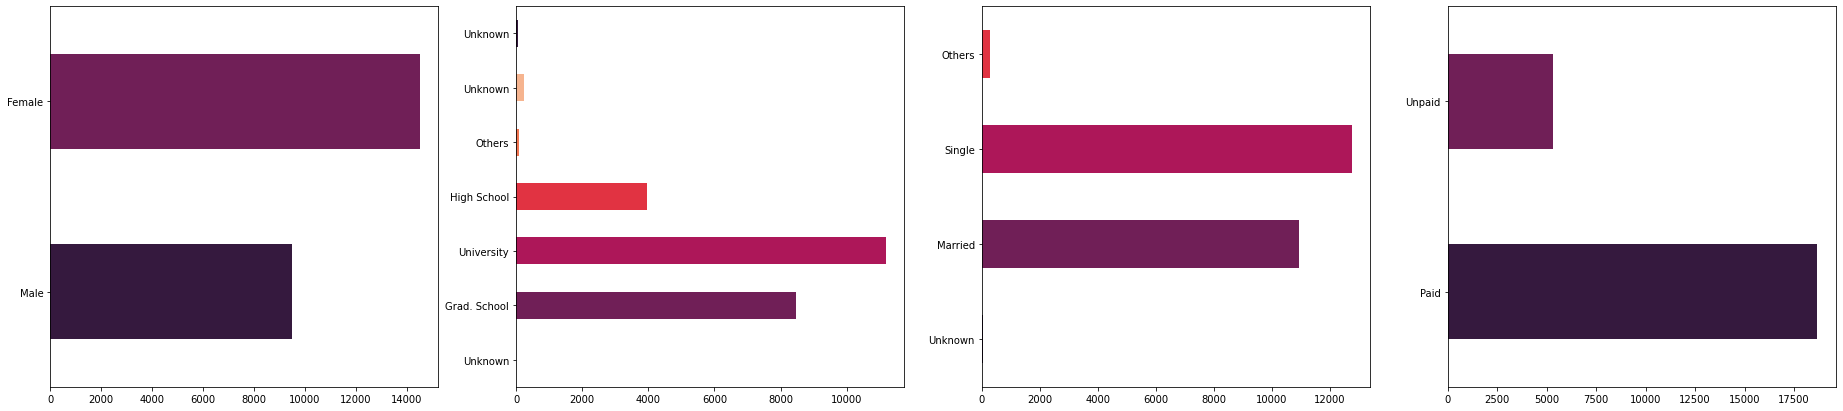

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(32, 7))
bar_columns = {
    'SEX': ['Male', 'Female'],
    'EDUCATION': ['Unknown', 'Grad. School', 'University', 'High School', 'Others', 'Unknown', 'Unknown'],
    'MARRIAGE': ['Unknown', 'Married', 'Single', 'Others'],
    'PAY_NEXT_MONTH': ['Paid', 'Unpaid']
}

colors = sns.color_palette("rocket")
for i, (column, labels) in enumerate(bar_columns.items()):
    X[column].value_counts().sort_index().plot.barh(ax=axes[i], color=colors)
    axes[i].set_yticklabels(labels)

In [12]:
X['EDUCATION'].value_counts()

2    11186
1     8481
3     3959
5      224
4       97
6       43
0       10
Name: EDUCATION, dtype: int64

In [13]:
X['MARRIAGE'].value_counts()

2    12747
1    10942
3      266
0       45
Name: MARRIAGE, dtype: int64

In [14]:
X['EDUCATION'] = X['EDUCATION'].replace([0, 5, 6], 4)
X['MARRIAGE'] = X['MARRIAGE'].replace([0], 3)

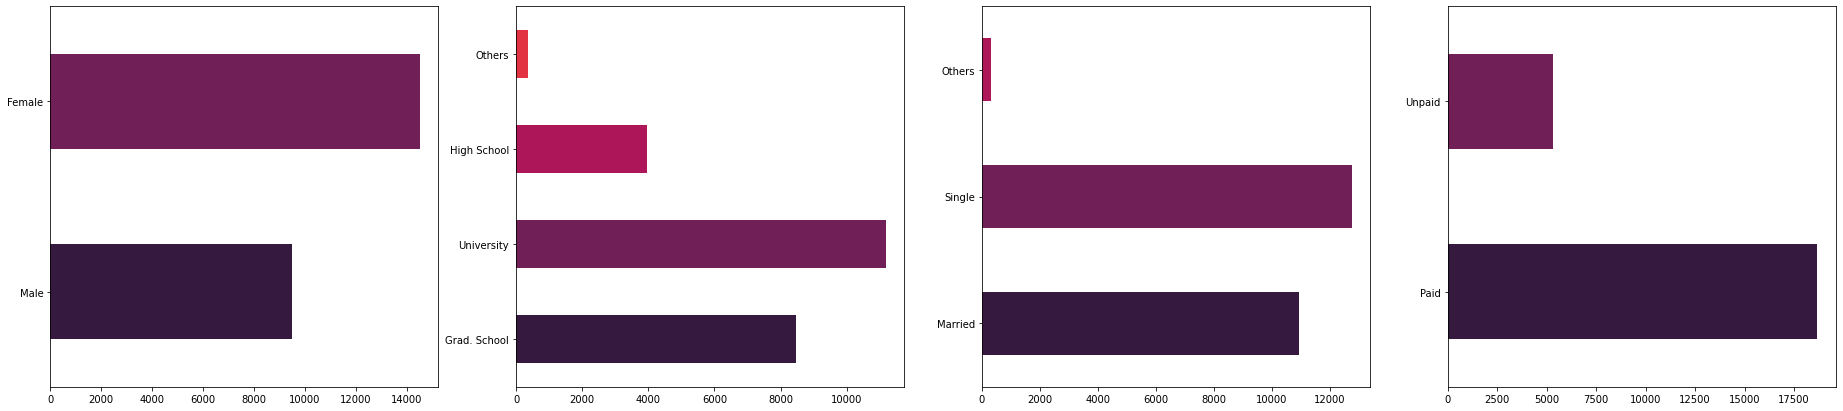

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(32, 7))
bar_columns = {
    'SEX': ['Male', 'Female'],
    'EDUCATION': ['Grad. School', 'University', 'High School', 'Others'],
    'MARRIAGE': ['Married', 'Single', 'Others'],
    'PAY_NEXT_MONTH': ['Paid', 'Unpaid']
}

colors = sns.color_palette("rocket")
for i, (column, labels) in enumerate(bar_columns.items()):
    X[column].value_counts().sort_index().plot.barh(ax=axes[i], color=colors)
    axes[i].set_yticklabels(labels)

For the rest of variables, only a few outliers with abnormal values in the `BILL_AMTX` or `PAY_AMTX` columns were dropped.
Anyways, this alteration affected only `6` records of the trainset.

array([[<AxesSubplot:title={'center':'AGE'}>,
        <AxesSubplot:title={'center':'BILL_AMT1'}>,
        <AxesSubplot:title={'center':'BILL_AMT2'}>,
        <AxesSubplot:title={'center':'BILL_AMT3'}>],
       [<AxesSubplot:title={'center':'BILL_AMT4'}>,
        <AxesSubplot:title={'center':'BILL_AMT5'}>,
        <AxesSubplot:title={'center':'BILL_AMT6'}>,
        <AxesSubplot:title={'center':'LIMIT_BAL'}>],
       [<AxesSubplot:title={'center':'PAY_1'}>,
        <AxesSubplot:title={'center':'PAY_2'}>,
        <AxesSubplot:title={'center':'PAY_3'}>,
        <AxesSubplot:title={'center':'PAY_4'}>],
       [<AxesSubplot:title={'center':'PAY_5'}>,
        <AxesSubplot:title={'center':'PAY_6'}>,
        <AxesSubplot:title={'center':'PAY_AMT1'}>,
        <AxesSubplot:title={'center':'PAY_AMT2'}>],
       [<AxesSubplot:title={'center':'PAY_AMT3'}>,
        <AxesSubplot:title={'center':'PAY_AMT4'}>,
        <AxesSubplot:title={'center':'PAY_AMT5'}>,
        <AxesSubplot:title={'center':'PAY_A

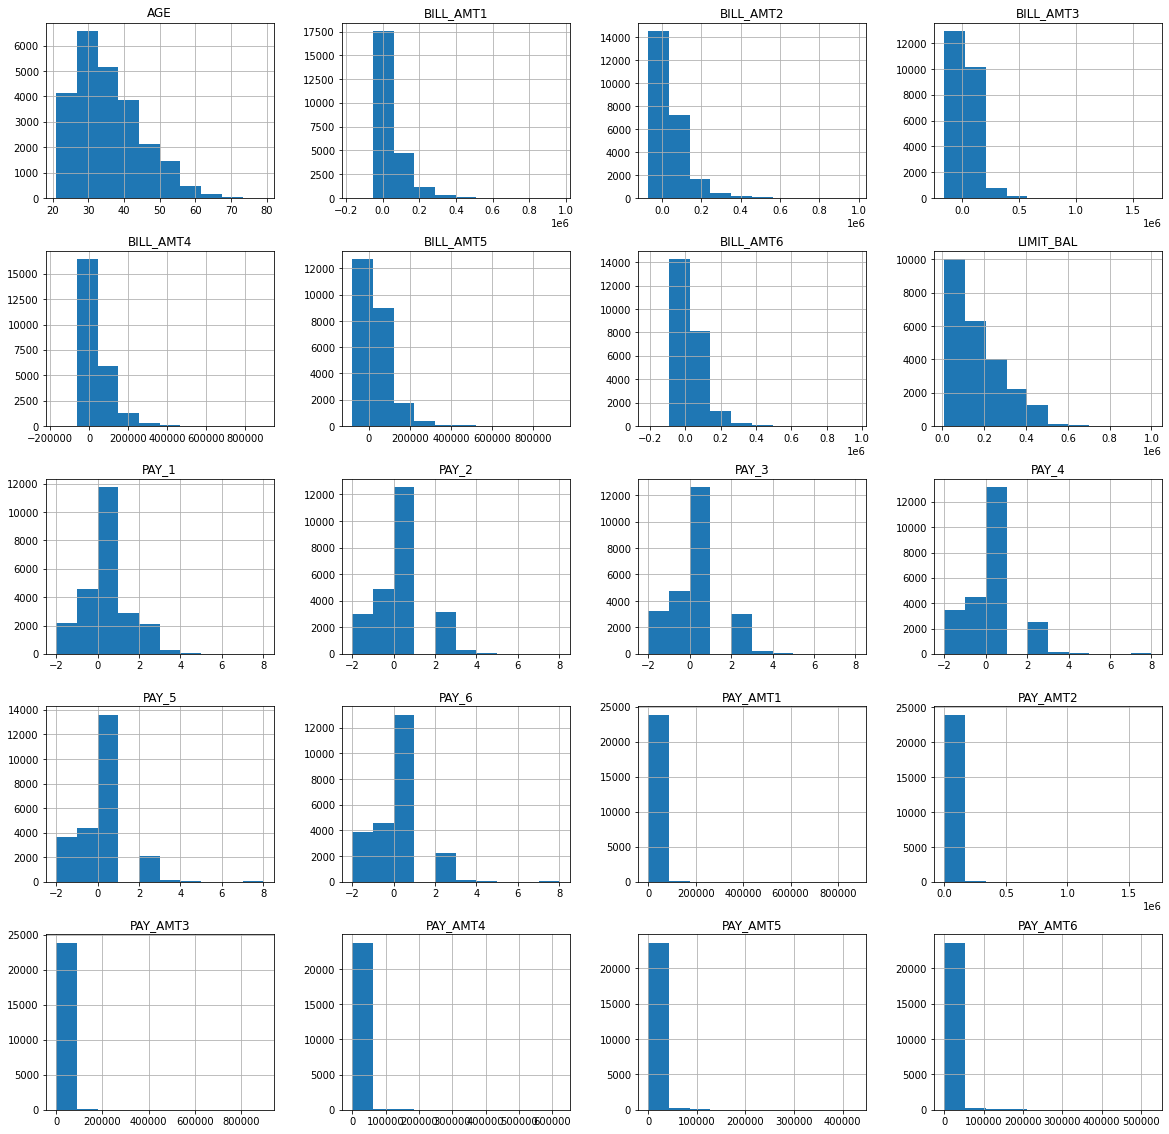

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

hist_columns = X.columns.difference(bar_columns.keys())
X[hist_columns].hist(ax=ax)

In [17]:
threshold = 750000

X = X[
    (X['BILL_AMT1'] < threshold) & (X['BILL_AMT2'] < threshold) & (X['BILL_AMT3'] < threshold) & (X['BILL_AMT4'] < threshold) & (X['BILL_AMT5'] < threshold) & (X['BILL_AMT6'] < threshold) &
    (X['PAY_AMT1'] < threshold) & (X['PAY_AMT2'] < threshold) & (X['PAY_AMT3'] < threshold) & (X['PAY_AMT4'] < threshold) & (X['PAY_AMT5'] < threshold) & (X['PAY_AMT6'] < threshold)
]

array([[<AxesSubplot:title={'center':'AGE'}>,
        <AxesSubplot:title={'center':'BILL_AMT1'}>,
        <AxesSubplot:title={'center':'BILL_AMT2'}>,
        <AxesSubplot:title={'center':'BILL_AMT3'}>],
       [<AxesSubplot:title={'center':'BILL_AMT4'}>,
        <AxesSubplot:title={'center':'BILL_AMT5'}>,
        <AxesSubplot:title={'center':'BILL_AMT6'}>,
        <AxesSubplot:title={'center':'LIMIT_BAL'}>],
       [<AxesSubplot:title={'center':'PAY_1'}>,
        <AxesSubplot:title={'center':'PAY_2'}>,
        <AxesSubplot:title={'center':'PAY_3'}>,
        <AxesSubplot:title={'center':'PAY_4'}>],
       [<AxesSubplot:title={'center':'PAY_5'}>,
        <AxesSubplot:title={'center':'PAY_6'}>,
        <AxesSubplot:title={'center':'PAY_AMT1'}>,
        <AxesSubplot:title={'center':'PAY_AMT2'}>],
       [<AxesSubplot:title={'center':'PAY_AMT3'}>,
        <AxesSubplot:title={'center':'PAY_AMT4'}>,
        <AxesSubplot:title={'center':'PAY_AMT5'}>,
        <AxesSubplot:title={'center':'PAY_A

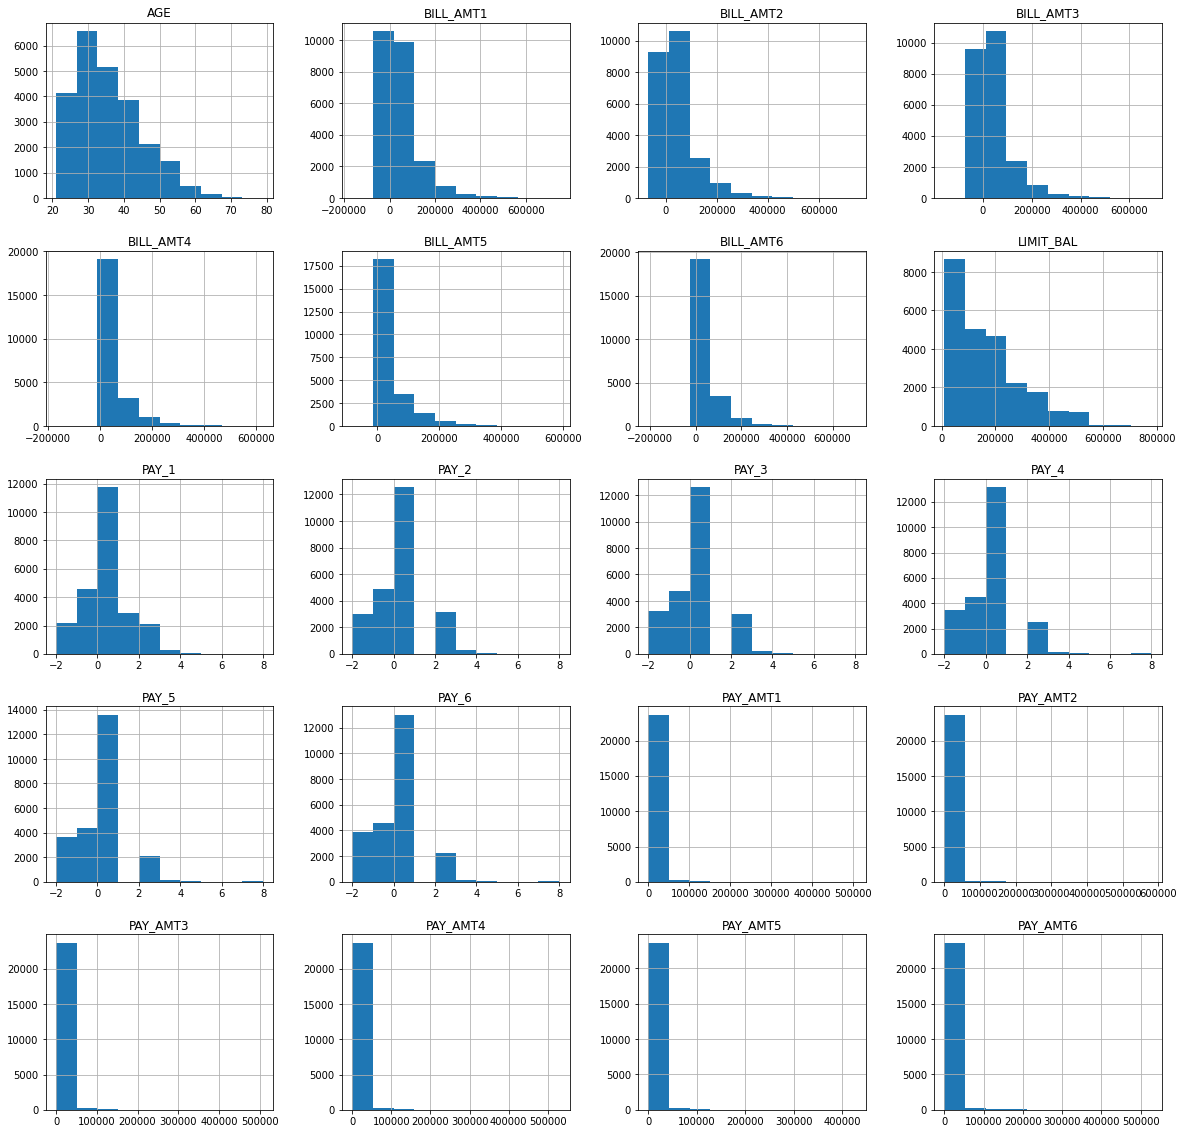

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

hist_columns = X.columns.difference(bar_columns.keys())
X[hist_columns].hist(ax=ax)

In [19]:
X_train, Y_train = X[X.columns[:-1]], pd.DataFrame(X[X.columns[-1]])
X_train.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,23994.000000,23994.000000,23994.000000,23994.000000,23994.000000,23994.000000,23994.000000,23994.000000,23994.000000,23994.000000,...,23994.000000,23994.00000,23994.000000,23994.000000,23994.000000,23994.000000,23994.000000,23994.000000,23994.000000,23994.000000
mean,167144.272735,1.604860,1.842877,1.557014,35.493915,-0.016587,-0.131324,-0.168084,-0.220305,-0.265108,...,46593.152955,42942.75373,40067.376344,38675.222347,5612.009752,5744.826582,5172.451154,4849.984121,4795.113820,5149.937359
std,129573.441944,0.488891,0.745585,0.522112,9.235833,1.126430,1.197658,1.191656,1.168065,1.132873,...,68047.333816,63735.12009,60138.893967,58849.288609,15828.504930,17491.892065,16297.574410,15800.055375,15410.490923,17434.128404
min,10000.000000,1.000000,1.000000,1.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-157264.000000,-170000.00000,-81334.000000,-209051.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2698.000000,2329.00000,1763.000000,1271.000000,1000.000000,860.000000,390.000000,285.250000,240.000000,111.250000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,20039.000000,19004.50000,18078.500000,17100.500000,2100.000000,2006.500000,1800.000000,1500.000000,1500.000000,1500.000000
75%,240000.000000,2.000000,2.000000,2.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,59517.250000,53855.50000,49990.500000,49060.750000,5005.000000,5000.000000,4500.000000,4000.000000,4016.000000,4000.000000
max,780000.000000,2.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,689643.000000,628699.00000,587067.000000,699944.000000,505000.000000,580464.000000,508229.000000,528897.000000,426529.000000,527143.000000


After the dataset modifications, we can proceed to scale the data start to build the network.
For this particular task, the `StandardScaler` was performing the best out of all the available scalers.

In [20]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

## Models
With the final train and test set we can start to build the model.

To test the performance of the model during the fitting phase, the training set was split in train set and validation set with a 80/20 ratio.

The network is composed in this way:

1. the input layer with 23 units (one for each feature)
2. a `Dense` layer with 64 units
3. a `Dropout` layer with a 20% drop rate
4. a `Dense` layer with 16 units
5. the output `Dense` layer a single unit

Throughout the various attempts, I introduced a kernel initialization with a seeded `GlorotUniform` distribution in all the `Dense` layers. Moreover, I decided to try different types of regularization on layers $2$ and $4$ to examine the different performances.

The order of the layers and the number of units were tweaked over various runs of the model to find a good balance between train and validation loss/accuracy/f1-score.

Several activation functions have been tested to decide the best fit for the model.
The functions I decided to include in the comparison are: `relu`, `gelu`, `elu`, `selu`, `leaky-relu`, `swish`.
During the tuning of the hyperparameters, I decided to ignore `selu`, `elu` and `swish`.
These functions were always performing utterly bad compated to the others.

The last layer always used a `sigmoid` activation function as its output value is restricted in the $[0, 1]$ range.

The network exploits the `Adam` optimizer, the `binary_crossentropy` loss function and an `EarlyStopping` mechanism which prevents the model to train further without noticable improvements.

A custom `f1_score` function was used to keep track this value as a metric during the training phase of the model.
This will allow me to display the F1 score over time and pick the best model.

In [21]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)
print('Train dimensions:', X_train.shape)

Train dimensions: (19195, 23)


In [22]:
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
        possible_positives = backend.sum(backend.round(backend.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + backend.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
        predicted_positives = backend.sum(backend.round(backend.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + backend.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision*recall) / (precision+recall+backend.epsilon()))


In [23]:
def compile_network(X, activation, regularizers):
    initializer = tf.keras.initializers.GlorotUniform(seed=1234) 
    model = Sequential([
        Dense(128, activation=activation, input_shape=(X.shape[1],), kernel_initializer=initializer, kernel_regularizer=regularizers[0]),
        Dropout(0.5),

        Dense(16, activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizers[1]),
        Dropout(0.1),

        Dense(1, activation='sigmoid', kernel_initializer=initializer)
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy', f1_score]
    )

    return model

In [24]:
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

get_custom_objects().update({'gelu': Activation(gelu)})
get_custom_objects().update({'leaky-relu': Activation(LeakyReLU(alpha=0.2))})


In [25]:
accuracy_early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=16,
    min_delta=0.001,
    restore_best_weights=True
)

In [26]:
histories = {}
models = {}
activations = ['relu', 'gelu', 'leaky-relu']
BATCH_SIZE = 64

regularization_kinds = {
    'Without': [
        None,
        None,
    ],
    'L1': [
        tf.keras.regularizers.l1(0.001),
        tf.keras.regularizers.l1(0.001),
    ],
    'L2': [
        tf.keras.regularizers.l2(0.001),
        tf.keras.regularizers.l2(0.001),
    ],
    'Mixed L2/L1': [
        tf.keras.regularizers.l2(0.001),
        tf.keras.regularizers.l1(0.001),
    ],
    'Mixed L1/L2': [
        tf.keras.regularizers.l1(0.001),
        tf.keras.regularizers.l2(0.001),
    ],
}

for regularizer, regularizers in regularization_kinds.items():
    histories[regularizer] = {}
    models[regularizer] = {}

    for activation in activations:
        print('[{} // {}] Training started...'.format(regularizer, activation))
        models[regularizer][activation] = compile_network(X_train, activation, regularizers)

        histories[regularizer][activation] = models[regularizer][activation].fit(X_train, Y_train,
            batch_size=BATCH_SIZE,
            epochs=200,
            verbose=2,
            validation_data=(X_validation, Y_validation),
            callbacks=[accuracy_early_stop]
        )
        print('')

        backend.clear_session()

0.4538 - val_accuracy: 0.8235 - val_f1_score: 0.4714
Epoch 17/200
300/300 - 0s - loss: 0.4605 - accuracy: 0.8169 - f1_score: 0.4531 - val_loss: 0.4530 - val_accuracy: 0.8220 - val_f1_score: 0.4526
Epoch 18/200
300/300 - 0s - loss: 0.4599 - accuracy: 0.8162 - f1_score: 0.4475 - val_loss: 0.4537 - val_accuracy: 0.8210 - val_f1_score: 0.4502
Epoch 19/200
300/300 - 0s - loss: 0.4595 - accuracy: 0.8154 - f1_score: 0.4452 - val_loss: 0.4542 - val_accuracy: 0.8233 - val_f1_score: 0.4591
Epoch 20/200
300/300 - 0s - loss: 0.4602 - accuracy: 0.8169 - f1_score: 0.4573 - val_loss: 0.4505 - val_accuracy: 0.8245 - val_f1_score: 0.4778
Epoch 21/200
300/300 - 0s - loss: 0.4598 - accuracy: 0.8172 - f1_score: 0.4526 - val_loss: 0.4513 - val_accuracy: 0.8229 - val_f1_score: 0.4670
Epoch 22/200
300/300 - 0s - loss: 0.4595 - accuracy: 0.8157 - f1_score: 0.4561 - val_loss: 0.4516 - val_accuracy: 0.8239 - val_f1_score: 0.4806
Epoch 23/200
300/300 - 0s - loss: 0.4589 - accuracy: 0.8157 - f1_score: 0.4566 - va

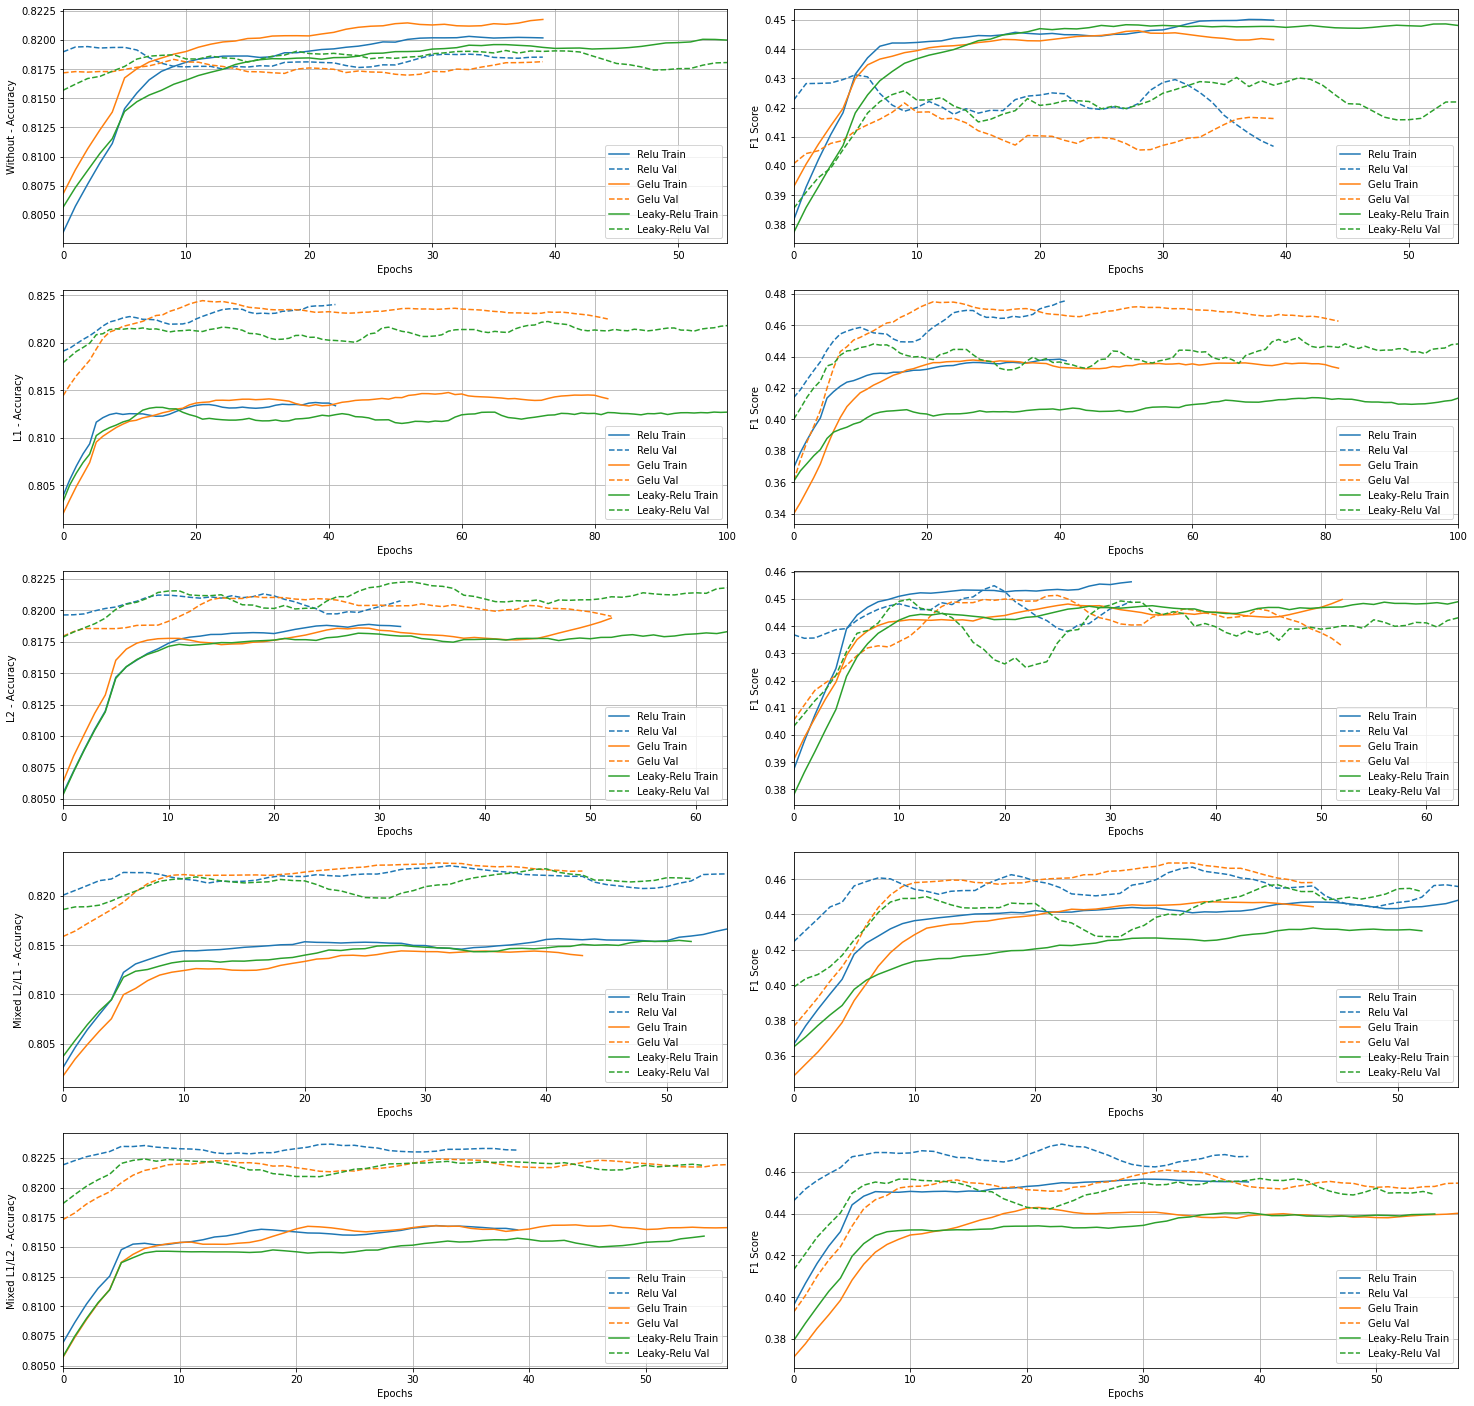

In [27]:
history_size = len(regularization_kinds.keys())

fig, axes = plt.subplots(history_size, 2, figsize=(25, 25))

acc_plotter = tfplots.HistoryPlotter(metric='accuracy', smoothing_std=1)
f1_plotter = tfplots.HistoryPlotter(metric='f1_score', smoothing_std=1)

fig.subplots_adjust(wspace=0.1)

for i, history in enumerate(histories.items()):
    regularizer, regularized_history = history

    ax = plt.subplot(history_size, 2, 2*i+1)
    acc_plotter.plot(regularized_history)
    ax.set_ylabel(regularizer + ' - ' + ax.get_ylabel())

    ax = plt.subplot(history_size, 2, 2*i+2)
    f1_plotter.plot(regularized_history)

## Regularization Effect

In [28]:
for regularizer, value in models.items():
    for activation, model in value.items():
        # Print only weights for relu activation function for easier comparison
        if activation != 'relu':
            break

        print('### {} regularization - {} activation ###'.format(regularizer, activation))
        print('> Sum of weights: {}'.format(sum(abs(model.weights[0][0])).numpy()))
        print('')


### Without regularization - relu activation ###
> Sum of weights: 13.268732070922852

### L1 regularization - relu activation ###
> Sum of weights: 0.6097608804702759

### L2 regularization - relu activation ###
> Sum of weights: 5.263174533843994

### Mixed L2/L1 regularization - relu activation ###
> Sum of weights: 2.604489326477051

### Mixed L1/L2 regularization - relu activation ###
> Sum of weights: 0.7369859218597412



## Final model
Out of all the available activation functions, I decided to use the `relu` function, whose resulted in a better overall F1 score.

Nevertheless, using `gelu` or `leaky-relu` would achieve similar result.

In [29]:
activation = 'relu'
regularizer = 'L1'

model = compile_network(X_train, activation, regularization_kinds[regularizer])
history = model.fit(X_train, Y_train,
    batch_size=BATCH_SIZE,
    epochs=200,
    verbose=2,
    validation_data=(X_validation, Y_validation),
    callbacks=[accuracy_early_stop]
)

Epoch 1/200
300/300 - 0s - loss: 0.8704 - accuracy: 0.7828 - f1_score: 0.2804 - val_loss: 0.6996 - val_accuracy: 0.8139 - val_f1_score: 0.3569
Epoch 2/200
300/300 - 0s - loss: 0.6284 - accuracy: 0.8090 - f1_score: 0.3892 - val_loss: 0.5557 - val_accuracy: 0.8229 - val_f1_score: 0.4490
Epoch 3/200
300/300 - 0s - loss: 0.5314 - accuracy: 0.8105 - f1_score: 0.4069 - val_loss: 0.4999 - val_accuracy: 0.8206 - val_f1_score: 0.4348
Epoch 4/200
300/300 - 0s - loss: 0.4956 - accuracy: 0.8125 - f1_score: 0.4071 - val_loss: 0.4779 - val_accuracy: 0.8231 - val_f1_score: 0.4586
Epoch 5/200
300/300 - 0s - loss: 0.4845 - accuracy: 0.8118 - f1_score: 0.4105 - val_loss: 0.4702 - val_accuracy: 0.8220 - val_f1_score: 0.4452
Epoch 6/200
300/300 - 0s - loss: 0.4768 - accuracy: 0.8111 - f1_score: 0.4136 - val_loss: 0.4666 - val_accuracy: 0.8223 - val_f1_score: 0.4508
Epoch 7/200
300/300 - 0s - loss: 0.4758 - accuracy: 0.8118 - f1_score: 0.4203 - val_loss: 0.4658 - val_accuracy: 0.8212 - val_f1_score: 0.4429

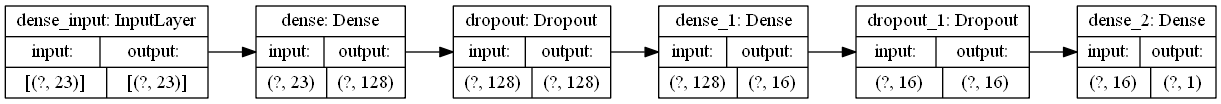

In [30]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               3072      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


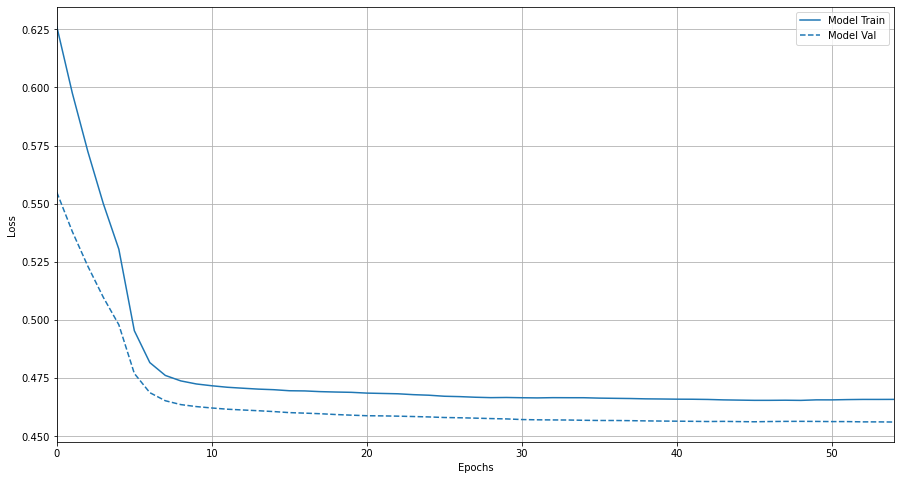

In [32]:
plotter = tfplots.HistoryPlotter(metric='loss', smoothing_std=1)

plt.figure(figsize=(15, 8))
plotter.plot({'Model': history})

# Prediction

Before the actual classification of the testset, it needs the same fixes presented in the `Preprocessing` section for the `EDUCATION` and `MARRIAGE` columns.

In [33]:
X_test['EDUCATION'] = X_test['EDUCATION'].replace([0, 5, 6], 4)
X_test['MARRIAGE'] = X_test['MARRIAGE'].replace([0], 3)
X_test = scaler.transform(X_test)

The resulting model is then used to classify the testset records.

In [34]:
Y_test = model.predict(X_test).round()

np.savetxt('results/Davide_Marchetti_815990_score2.txt', Y_test, newline='\n', fmt='%d')